### Spatially-resolved SED fitting

A demonstration of an optimised method for spatially-resolved SED fitting, using [bagpipes](https://bagpipes.readthedocs.io/).

Following on from last time, let's set up the basic parameters and directories.

In [1]:
from pathlib import Path
import yaml
import os

# As always, setup some directory structure
root_dir = Path("/media") / "sharedData" / "data"
out_base_dir = root_dir / "2024_08_16_A2744_v4" / "glass_niriss"
bin_data_dir = out_base_dir / "binned_data"

# The location of the reprojected segmentation map
repr_seg_path = out_base_dir / "PSF_matched_data" / "repr_seg_map.fits"

# Load the info for the ancillary data
with open(out_base_dir / "conv_ancillary_data.yaml", "r") as file:
    info_dict = yaml.safe_load(file)

Fitting the SED of an object using broad-band photometry requires knowledge of the filter sensitivity curves. To save some time for anyone interested in running this, the ``glass-niriss`` repository does include a filter directory under ``example_notebooks/``, for the bands used in processing A2744. For other instruments, [sedpy](https://sedpy.readthedocs.io/en/latest/) or [SVO](http://svo2.cab.inta-csic.es/theory/fps/) are excellent resources.

In [2]:
# Create the [bag]pipes directory
pipes_dir = out_base_dir / "sed_fitting" / "pipes"
pipes_dir.mkdir(exist_ok=True, parents=True)

# Create the filter directory; populate as needed
filter_dir = pipes_dir / "filter_throughputs"
filter_dir.mkdir(exist_ok=True, parents=True)

Load the

In [3]:
filter_list = []
for key in info_dict.keys():
    filter_list.append(str(filter_dir / f"{key}.txt"))

In [4]:
atlas_dir = pipes_dir / "atlases"
atlas_dir.mkdir(exist_ok=True, parents=True)

In [5]:
obj_id = 2495
obj_z = 1.3397

obj_id = 3217
obj_z = 2.6724

obj_id = 2186
obj_z = 0.3033

# obj_id = 4196
# obj_z = 0.2966
obj_id = 2618
obj_z = 0.3006
obj_id = 2398
obj_z = 0.3006

num_age_bins = 7

from astropy.cosmology import FlatLambdaCDM
import numpy as np

# Set up necessary variables for cosmological calculations.
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
age_at_z = cosmo.age(obj_z).value

# Minimum age bin of 30 Myr
min_age_bin = 30

age_bins = np.geomspace(min_age_bin,age_at_z*1e3,num=num_age_bins)

age_bins = np.insert(age_bins,0,0.)

print (age_bins)
# print (age_at_z)

fit_instr = np.load(
    Path("/media") / "sharedData" / "data"
    / "2024_02_14_RPS/PSF_matching/bagpipes/"
    / f"fit_info_F0083_leja_100_-200_200_-100_cvt_wvt_dust_corr_7_bins.npy",
    allow_pickle=True,
).item()
fit_instr["continuity"]["metallicity_prior"] = "Gaussian"
fit_instr["continuity"]["massformed"] = (3,11)
# fit_instr["continuity"]["bin_edges"] = [0.,30.,100.,300.,500.,1000.,2000.,4000.]
fit_instr["continuity"]["bin_edges"] = age_bins.tolist()
# [0.0, 30.0, 100.0, 300.0, 1000.0, 2500.0, 7500.0, 10000.0]
fit_instr["dust"]["eta"] = 2.
fit_instr["redshift"] = obj_z

print (fit_instr)

[    0.            30.            79.05196704   208.30711644
   548.90291012  1446.39515869  3811.3460805  10043.14682478]
{'redshift': 0.3006, 'continuity': {'massformed': (3, 11), 'metallicity': (0.0, 3.0), 'metallicity_prior_mu': 1.0, 'metallicity_prior_sigma': 0.5, 'bin_edges': [0.0, 30.0, 79.05196704245525, 208.30711644271452, 548.9029101246119, 1446.3951586892867, 3811.3460805024115, 10043.146824775593], 'dsfr1': (-10.0, 10.0), 'dsfr1_prior': 'student_t', 'dsfr2': (-10.0, 10.0), 'dsfr2_prior': 'student_t', 'dsfr3': (-10.0, 10.0), 'dsfr3_prior': 'student_t', 'dsfr4': (-10.0, 10.0), 'dsfr4_prior': 'student_t', 'dsfr5': (-10.0, 10.0), 'dsfr5_prior': 'student_t', 'dsfr6': (-10.0, 10.0), 'dsfr6_prior': 'student_t', 'dsfr7': (-10.0, 10.0), 'dsfr7_prior': 'student_t', 'metallicity_prior': 'Gaussian'}, 'dust': {'type': 'Cardelli', 'Av': (0.0, 2.0), 'eta': 2.0}, 'nebular': {'logU': (-3.5, -2)}, 't_bc': 0.02}


In [6]:
from glass_niriss.sed import AtlasGenerator

n_samples = 1e5
n_cores = 16

remake_atlas = False
atlas_path = atlas_dir / f"z_{obj_z}_{obj_z}_{n_samples:.2E}.hdf5"

if not atlas_path.is_file() or remake_atlas:

    atlas_gen = AtlasGenerator(
        fit_instructions=fit_instr,
        filt_list=filter_list,
        phot_units="ergscma",
    )

    atlas_gen.gen_samples(n_samples=n_samples, parallel=n_cores)

    atlas_gen.write_samples(filepath=atlas_path)

In [7]:
from glass_niriss.pipeline import load_photom_bagpipes
from glass_niriss.sed import AtlasFitter
from functools import partial

hexbin = True
bin_diameter = 12
target_sn = 100
sn_filter = "jwst-nircam-f115w"

binned_name = f"{obj_id}_{"hexbin" if hexbin else "vorbin"}_{bin_diameter}_{target_sn}"
phot_cat_path = bin_data_dir / f"{binned_name}_data.fits"

load_fn = partial(load_photom_bagpipes, phot_cat = phot_cat_path, cat_hdu_index="PHOT_CAT")

fit = AtlasFitter(
    fit_instructions=fit_instr,
    atlas_path=atlas_path,
    out_path=out_base_dir,
)

from astropy.table import Table
obs_table = Table.read(bin_data_dir / f"{binned_name}_data.fits", hdu="PHOT_CAT")

cat_IDs = np.arange(len(obs_table))[:]
redshifts = [obj_z] * len(cat_IDs)

run_name = f"{binned_name}_z_{obj_z}_{obj_z}_{n_samples:.2E}"

catalogue_out_path = fit.out_path / Path(
    f"{run_name}.fits"
)
if not catalogue_out_path.is_file():

    fit.fit_catalogue(
        IDs=cat_IDs,
        load_data=load_fn,
        spectrum_exists=False,
        make_plots=False,
        cat_filt_list=filter_list,
        redshifts=redshifts,
        run=f"{run_name}",
        parallel=8,
    )
    print(fit.cat)
    fit.cat.write(catalogue_out_path)
else:
    fit.cat = Table.read(catalogue_out_path)

{'redshift': 0.3006, 'continuity': {'massformed': (3, 11), 'metallicity': (0.0, 3.0), 'metallicity_prior_mu': 1.0, 'metallicity_prior_sigma': 0.5, 'bin_edges': [0.0, 30.0, 79.05196704245525, 208.30711644271452, 548.9029101246119, 1446.3951586892867, 3811.3460805024115, 10043.146824775593], 'dsfr1': (-10.0, 10.0), 'dsfr1_prior': 'student_t', 'dsfr2': (-10.0, 10.0), 'dsfr2_prior': 'student_t', 'dsfr3': (-10.0, 10.0), 'dsfr3_prior': 'student_t', 'dsfr4': (-10.0, 10.0), 'dsfr4_prior': 'student_t', 'dsfr5': (-10.0, 10.0), 'dsfr5_prior': 'student_t', 'dsfr6': (-10.0, 10.0), 'dsfr6_prior': 'student_t', 'dsfr7': (-10.0, 10.0), 'dsfr7_prior': 'student_t', 'metallicity_prior': 'Gaussian'}, 'dust': {'type': 'Cardelli', 'Av': (0.0, 2.0), 'eta': 2.0}, 'nebular': {'logU': (-3.5, -2)}, 't_bc': 0.02}
Fitting 535 objects using 8 process(es).


 26%|██▌       | 140/535 [00:00<00:02, 178.28it/s]/media/sharedData/python/py3.12_GLASS_pipeline/code/GLASS-NIRISS/src/glass_niriss/pipeline/sed_fits.py:48: RuntimeWarning: invalid value encountered in sqrt
  errs.append(np.sqrt(phot_cat[c][row_idx]))
/media/sharedData/python/py3.12_GLASS_pipeline/code/GLASS-NIRISS/src/glass_niriss/pipeline/sed_fits.py:48: RuntimeWarning: invalid value encountered in sqrt
  errs.append(np.sqrt(phot_cat[c][row_idx]))
/media/sharedData/python/py3.12_GLASS_pipeline/code/GLASS-NIRISS/src/glass_niriss/pipeline/sed_fits.py:48: RuntimeWarning: invalid value encountered in sqrt
  errs.append(np.sqrt(phot_cat[c][row_idx]))
 35%|███▍      | 187/535 [00:03<00:10, 33.77it/s] /media/sharedData/python/py3.12_GLASS_pipeline/code/GLASS-NIRISS/src/glass_niriss/pipeline/sed_fits.py:48: RuntimeWarning: invalid value encountered in sqrt
  errs.append(np.sqrt(phot_cat[c][row_idx]))
 70%|██████▉   | 374/535 [00:07<00:02, 54.41it/s]/media/sharedData/python/py3.12_GLASS_pipel

#ID continuity:dsfr1_16  ...    log_evidence    log_evidence_err
--- -------------------- ... ------------------ ----------------
  0 -0.24192620231311024 ...  818.9254854868528              nan
  1  -0.7219482301184051 ... 1234.0689765911413              nan
  2  -0.8124089748961899 ...  1306.555547450165              nan
  3  -0.6543210484150205 ... 1499.1869629980713              nan
  4   -0.828660782498053 ...  1387.293062228181              nan
  5  -1.0031164883190986 ... 1281.9193814242653              nan
  6  -1.0016935554313773 ...  1225.225720000277              nan
  7  -0.7765542819505186 ... 1293.5060040836138              nan
  8  -0.9690760642450267 ... 1221.0429490680995              nan
  9   -0.693416358246661 ... 1357.8890363482199              nan
...                  ... ...                ...              ...
525   -1.051332755742192 ... 1244.6855010838615              nan
526  -0.8332840639086517 ...  1052.831488595235              nan
527  -0.5829860812108834 

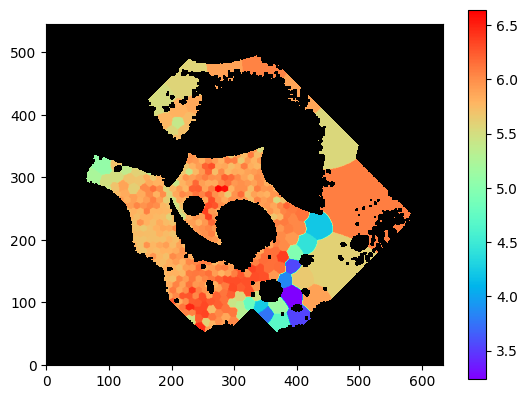

In [8]:
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from astropy.io import fits
fig, axs = plt.subplots(1, 1)

seg_map = fits.getdata(phot_cat_path, hdu="SEG_MAP")

plot_map = np.full_like(seg_map, np.nan, dtype=float)
for row in fit.cat:
    plot_map[seg_map == int(row["#ID"])] = (
        row[
            # "continuity:massformed_50"
            # "stellar_mass_50"
            # "ssfr_50"
            # "sfr_50"
            # "continuity:metallicity_50"
            "mass_weighted_age_50"
            # "dust:Av_50"
            # "dust:eta"
            # "nebular:logU_50"
        ]
        # *row[
        #     "dust:eta_50"
        # ]
        # /
        # -
        # np.log10(
        # (len((seg_map == int(row["#ID"])).nonzero()[0])
        # * ((0.04 * 4.63) ** 2))
        # )
    )
plot_map[seg_map==0] = np.nan
im = axs.imshow(
    plot_map,
    # np.log10(plot_map),
    origin="lower",
    # vmin=3,
    # vmax=9,
    # vmin=-4,
    # vmax=1,
    # vmin=-12,
    # vmax=-8,
    # vmin=-8,
    # vmax=-3,
    # cmap="plasma",
    # vmin=0,
    cmap="rainbow"
    # cmap = cmc.lajolla
)
axs.set_facecolor("k")
plt.colorbar(im)

plt.show()